In [ ]:
# Univariate time series forecasting using LSTM
# https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
# Time Series Forecasting with the Long Short-Term Memory Network in Python.PDF
# /users/akuppam/documents/Hprog/Py/LSTM/"

In [3]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
	#return datetime.strptime('190'+x, '%Y-%m')
	return datetime.strptime(x, '%Y-%m-%d')
	#return datetime.strptime(x, '%mm/%dd/%YY')
# ValueError: time data '1902016-01-01' does not match format '%Y-%m'

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 
# load dataset
#series = read_csv('ss2.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = read_csv('AMRNotPaid.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
# take last 200 rows as test data
train, test = supervised_values[0:-200], supervised_values[-200:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model (epochs were originally 3000 - changed it to 100)
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('TestData_Day#=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-200:], predictions))
    print('Test RMSE: %.3f' % rmse)

# line plot of observed vs predicted
pyplot.plot(raw_values[-200:])
pyplot.plot(predictions)
pyplot.show()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
TestData_Day#=1, Predicted=11503.665892, Expected=10862.000000


ValueError: Found input variables with inconsistent numbers of samples: [200, 1]

In [84]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move 
                         forward on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = lstm_model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    preds_moving = scaler.inverse_transform(preds_moving)
    
    return preds_moving

pyplot.plot(actuals)
pyplot.plot(preds_moving)
pyplot.show()

In [ ]:
pyplot.plot(actuals)
pyplot.plot(preds_moving)
pyplot.show()

In [74]:
moving_test_window = [test[0,:].tolist()]
moving_test_window = np.array(moving_test_window)
moving_test_window

array([[-847., -388.]])

In [ ]:
input_shape=X_train.shape[1:]

In [77]:
moving_test_window = [test[0,:].tolist()]
moving_test_window

[[-847.0, -388.0]]

In [78]:

moving_test_window

AttributeError: 'tuple' object has no attribute 'tolist'

In [75]:
preds_one_step = lstm_model.predict(moving_test_window)

ValueError: Error when checking input: expected lstm_4_input to have 3 dimensions, but got array with shape (1, 2)

In [85]:
preds_moving = moving_test_window_preds(400)

ValueError: Error when checking input: expected lstm_4_input to have 3 dimensions, but got array with shape (1, 2)

In [67]:
test.shape

(200, 2)

In [82]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [83]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('TestData_Day#=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

TestData_Day#=1, Predicted=10294.223767, Expected=10862.000000
TestData_Day#=2, Predicted=10257.745048, Expected=9871.000000
TestData_Day#=3, Predicted=9731.217570, Expected=10910.000000
TestData_Day#=4, Predicted=11001.403450, Expected=13000.000000
TestData_Day#=5, Predicted=12563.679227, Expected=12547.000000
TestData_Day#=6, Predicted=12086.881340, Expected=12218.000000
TestData_Day#=7, Predicted=12072.122101, Expected=12012.000000
TestData_Day#=8, Predicted=12097.774561, Expected=11573.000000
TestData_Day#=9, Predicted=11824.349715, Expected=12130.000000
TestData_Day#=10, Predicted=12462.755395, Expected=14136.000000
TestData_Day#=11, Predicted=13896.248371, Expected=13184.000000
TestData_Day#=12, Predicted=12548.204731, Expected=12524.000000
TestData_Day#=13, Predicted=12260.720792, Expected=12029.000000
TestData_Day#=14, Predicted=12033.908552, Expected=11397.000000
TestData_Day#=15, Predicted=11644.574781, Expected=10349.000000
TestData_Day#=16, Predicted=10801.258025, Expected=

In [51]:
import pandas as pd
amrnp = pd.read_csv('AMRNotPaid.csv')

In [65]:
#yhatFF = lstm_model.predict(train, 1)
train = train.reshape(1, len(train))
yhatFF = lstm_model.predict(train, batch_size=1)

ValueError: cannot reshape array of size 1636 into shape (1,818)

In [66]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_4 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [56]:
yhatFF

0.0070470423

In [64]:
train.shape

(818, 2)

In [57]:
X

array([0.3199241])

In [52]:
amrnp.tail()

,date,nb
1014,2018-10-11,7189
1015,2018-10-12,6169
1016,2018-10-13,6026
1017,2018-10-14,7672
1018,2018-10-15,7552


In [37]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [48]:
train.shape

(1006, 2)

In [49]:
test.shape

(12, 2)

In [ ]:
# break it into parts and examine each step

In [3]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
	#return datetime.strptime('190'+x, '%Y-%m')
	return datetime.strptime(x, '%Y-%m-%d')
	#return datetime.strptime(x, '%mm/%dd/%YY')
# ValueError: time data '1902016-01-01' does not match format '%Y-%m'

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# load dataset
series = read_csv('AMRNotPaid.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [5]:
series.head()

date
2016-01-01    5500
2016-01-02    6513
2016-01-03    7602
2016-01-04    8871
2016-01-05    9828
Name: nb, dtype: int64

In [6]:
df_super = timeseries_to_supervised(series)
df_super.head()

,nb,nb
date,,
2016-01-01,0.0,5500
2016-01-02,5500.0,6513
2016-01-03,6513.0,7602
2016-01-04,7602.0,8871
2016-01-05,8871.0,9828


In [7]:
df_super_diff = difference(series, interval = 1)
df_super_diff.head()

0    1013
1    1089
2    1269
3     957
4     275
dtype: int64

In [8]:
differenced = df_super_diff
# invert transform (to original series)
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

0     6513
1     7602
2     8871
3     9828
4    10103
dtype: int64


In [11]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
    # if 'train' is a DataFrame, then change it to train.values.reshape
	train = train.values.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.values.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [12]:
# split data into train and test-sets
# take last 200 rows as test data
supervised_values = df_super
train, test = supervised_values[0:-200], supervised_values[-200:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
train.head()

,nb,nb
date,,
2016-01-01,0.0,5500
2016-01-02,5500.0,6513
2016-01-03,6513.0,7602
2016-01-04,7602.0,8871
2016-01-05,8871.0,9828


In [14]:
test.tail()

,nb,nb
date,,
2018-10-11,7325.0,7189
2018-10-12,7189.0,6169
2018-10-13,6169.0,6026
2018-10-14,6026.0,7672
2018-10-15,7672.0,7552


In [15]:
train_scaled

array([[-1.        , -0.57996927],
       [-0.34566653, -0.43846906],
       [-0.2251502 , -0.28635284],
       ...,
       [ 0.56290524,  0.38902081],
       [ 0.47962644,  0.34152815],
       [ 0.43917673,  0.22321553]])

In [16]:
test_scaled

array([[ 0.33840937,  0.16901802],
       [ 0.29224912,  0.03059086],
       [ 0.17435013,  0.17572287],
       [ 0.29795967,  0.46766308],
       [ 0.54660639,  0.40438609],
       [ 0.4927131 ,  0.35842995],
       [ 0.45357207,  0.32965498],
       [ 0.4290643 ,  0.26833357],
       [ 0.3768366 ,  0.34613773],
       [ 0.44310273,  0.62634446],
       [ 0.68175599,  0.493365  ],
       [ 0.56849682,  0.40117335],
       [ 0.4899768 ,  0.33202961],
       [ 0.43108679,  0.24374913],
       [ 0.35589792,  0.09735997],
       [ 0.23121766,  0.15979885],
       [ 0.28439712,  0.54616567],
       [ 0.61346737,  0.48428551],
       [ 0.56076379,  0.31415002],
       [ 0.41585866,  0.22684733],
       [ 0.34150259,  0.20729152],
       [ 0.32484683,  0.07221679],
       [ 0.20980311,  0.0018159 ],
       [ 0.14984237,  0.30465149],
       [ 0.40776872,  0.47799972],
       [ 0.55541015,  0.28244168],
       [ 0.38885254,  0.36890627],
       [ 0.4624948 ,  0.16594496],
       [ 0.28963179,

In [17]:
# load dataset
#series = read_csv('ss2.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = read_csv('AMRNotPaid.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
# take last 200 rows as test data
train, test = supervised_values[0:-200], supervised_values[-200:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [18]:
train

array([[   0., 1013.],
       [1013., 1089.],
       [1089., 1269.],
       ...,
       [-724., -700.],
       [-700., -340.],
       [-340., -847.]])

In [19]:
test_scaled

array([[ 0.33840937,  0.16901802],
       [ 0.29224912,  0.03059086],
       [ 0.17435013,  0.17572287],
       [ 0.29795967,  0.46766308],
       [ 0.54660639,  0.40438609],
       [ 0.4927131 ,  0.35842995],
       [ 0.45357207,  0.32965498],
       [ 0.4290643 ,  0.26833357],
       [ 0.3768366 ,  0.34613773],
       [ 0.44310273,  0.62634446],
       [ 0.68175599,  0.493365  ],
       [ 0.56849682,  0.40117335],
       [ 0.4899768 ,  0.33202961],
       [ 0.43108679,  0.24374913],
       [ 0.35589792,  0.09735997],
       [ 0.23121766,  0.15979885],
       [ 0.28439712,  0.54616567],
       [ 0.61346737,  0.48428551],
       [ 0.56076379,  0.31415002],
       [ 0.41585866,  0.22684733],
       [ 0.34150259,  0.20729152],
       [ 0.32484683,  0.07221679],
       [ 0.20980311,  0.0018159 ],
       [ 0.14984237,  0.30465149],
       [ 0.40776872,  0.47799972],
       [ 0.55541015,  0.28244168],
       [ 0.38885254,  0.36890627],
       [ 0.4624948 ,  0.16594496],
       [ 0.28963179,

In [20]:
X, y = train[:, 0:-1], train[:, -1]

In [21]:
X[0:10]

array([[   0.],
       [1013.],
       [1089.],
       [1269.],
       [ 957.],
       [ 275.],
       [ -39.],
       [-505.],
       [-678.],
       [ 939.]])

In [22]:
y[0:10]

array([1013., 1089., 1269.,  957.,  275.,  -39., -505., -678.,  939.,
        674.])

In [23]:
X = X.reshape(X.shape[0], 1, X.shape[1])

In [ ]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

In [24]:
X

array([[[ 0.000e+00]],

       [[ 1.013e+03]],

       [[ 1.089e+03]],

       [[ 1.269e+03]],

       [[ 9.570e+02]],

       [[ 2.750e+02]],

       [[-3.900e+01]],

       [[-5.050e+02]],

       [[-6.780e+02]],

       [[ 9.390e+02]],

       [[ 6.740e+02]],

       [[-2.210e+02]],

       [[-1.420e+02]],

       [[-2.060e+02]],

       [[-6.190e+02]],

       [[-8.210e+02]],

       [[ 8.040e+02]],

       [[ 9.530e+02]],

       [[-4.270e+02]],

       [[ 1.300e+01]],

       [[ 2.240e+02]],

       [[-1.138e+03]],

       [[-2.670e+02]],

       [[ 5.670e+02]],

       [[ 9.780e+02]],

       [[ 2.230e+02]],

       [[ 6.000e+00]],

       [[-8.420e+02]],

       [[-3.770e+02]],

       [[-6.380e+02]],

       [[ 1.378e+03]],

       [[ 1.064e+03]],

       [[-2.720e+02]],

       [[-8.700e+01]],

       [[-5.080e+02]],

       [[-9.270e+02]],

       [[-8.120e+02]],

       [[ 7.600e+01]],

       [[ 1.068e+03]],

       [[ 1.094e+03]],

       [[-6.320e+02]],

       [[-1.980e

In [61]:
X[0:10]

array([[[   0.]],

       [[1013.]],

       [[1089.]],

       [[1269.]],

       [[ 957.]],

       [[ 275.]],

       [[ -39.]],

       [[-505.]],

       [[-678.]],

       [[ 939.]]])

In [66]:
neurons = 4
batch_size = 1
model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [68]:
layer = LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)

In [70]:
X.shape[1]

1

In [71]:
X.shape[2]

1

TestData_Day#=1, Predicted=11375.487758, Expected=10862.000000
TestData_Day#=2, Predicted=11572.014625, Expected=9871.000000
TestData_Day#=3, Predicted=10853.296364, Expected=10910.000000
TestData_Day#=4, Predicted=12091.443306, Expected=13000.000000
TestData_Day#=5, Predicted=12579.051066, Expected=12547.000000
TestData_Day#=6, Predicted=12140.886474, Expected=12218.000000
TestData_Day#=7, Predicted=11753.136876, Expected=12012.000000
TestData_Day#=8, Predicted=11568.347954, Expected=11573.000000
TestData_Day#=9, Predicted=11217.010511, Expected=12130.000000
TestData_Day#=10, Predicted=12018.821586, Expected=14136.000000
TestData_Day#=11, Predicted=13296.877321, Expected=13184.000000
TestData_Day#=12, Predicted=12814.747414, Expected=12524.000000
TestData_Day#=13, Predicted=12159.713596, Expected=12029.000000
TestData_Day#=14, Predicted=12224.183215, Expected=11397.000000
TestData_Day#=15, Predicted=12190.354831, Expected=10349.000000
TestData_Day#=16, Predicted=11742.884206, Expected

TestData_Day#=1, Predicted=11411.770096, Expected=10862.000000
TestData_Day#=2, Predicted=11266.095959, Expected=9871.000000
TestData_Day#=3, Predicted=10289.810392, Expected=10910.000000
TestData_Day#=4, Predicted=11493.807886, Expected=13000.000000
TestData_Day#=5, Predicted=12792.532380, Expected=12547.000000
TestData_Day#=6, Predicted=11806.183567, Expected=12218.000000
TestData_Day#=7, Predicted=11763.941325, Expected=12012.000000
TestData_Day#=8, Predicted=11671.202892, Expected=11573.000000
TestData_Day#=9, Predicted=11385.345276, Expected=12130.000000
TestData_Day#=10, Predicted=12056.580526, Expected=14136.000000
TestData_Day#=11, Predicted=13511.727220, Expected=13184.000000
TestData_Day#=12, Predicted=12346.269878, Expected=12524.000000
TestData_Day#=13, Predicted=12263.532056, Expected=12029.000000
TestData_Day#=14, Predicted=12054.100627, Expected=11397.000000
TestData_Day#=15, Predicted=11674.598270, Expected=10349.000000
TestData_Day#=16, Predicted=10827.314223, Expected

TestData_Day#=1, Predicted=11387.927948, Expected=10862.000000
TestData_Day#=2, Predicted=11269.846981, Expected=9871.000000
TestData_Day#=3, Predicted=10573.619303, Expected=10910.000000
TestData_Day#=4, Predicted=11688.733338, Expected=13000.000000
TestData_Day#=5, Predicted=13135.987415, Expected=12547.000000
TestData_Day#=6, Predicted=12146.724976, Expected=12218.000000
TestData_Day#=7, Predicted=11470.275027, Expected=12012.000000
TestData_Day#=8, Predicted=11367.378009, Expected=11573.000000
TestData_Day#=9, Predicted=11354.164701, Expected=12130.000000
TestData_Day#=10, Predicted=12204.471433, Expected=14136.000000
TestData_Day#=11, Predicted=14025.528996, Expected=13184.000000
TestData_Day#=12, Predicted=13104.412790, Expected=12524.000000
TestData_Day#=13, Predicted=12502.673544, Expected=12029.000000
TestData_Day#=14, Predicted=12134.278485, Expected=11397.000000
TestData_Day#=15, Predicted=11689.841243, Expected=10349.000000
TestData_Day#=16, Predicted=10873.903272, Expected

TestData_Day#=1, Predicted=11459.713419, Expected=10862.000000
TestData_Day#=2, Predicted=11788.075326, Expected=9871.000000
TestData_Day#=3, Predicted=11154.122103, Expected=10910.000000
TestData_Day#=4, Predicted=12375.033473, Expected=13000.000000
TestData_Day#=5, Predicted=12396.615102, Expected=12547.000000
TestData_Day#=6, Predicted=12339.288723, Expected=12218.000000
TestData_Day#=7, Predicted=12162.608613, Expected=12012.000000
TestData_Day#=8, Predicted=11998.696943, Expected=11573.000000
TestData_Day#=9, Predicted=11575.943931, Expected=12130.000000
TestData_Day#=10, Predicted=12285.088838, Expected=14136.000000
TestData_Day#=11, Predicted=13581.931782, Expected=13184.000000
TestData_Day#=12, Predicted=12613.615001, Expected=12524.000000
TestData_Day#=13, Predicted=12014.009529, Expected=12029.000000
TestData_Day#=14, Predicted=11921.074753, Expected=11397.000000
TestData_Day#=15, Predicted=11867.458091, Expected=10349.000000
TestData_Day#=16, Predicted=11356.901530, Expected

TestData_Day#=1, Predicted=11285.807778, Expected=10862.000000
TestData_Day#=2, Predicted=11053.236420, Expected=9871.000000
TestData_Day#=3, Predicted=10098.042872, Expected=10910.000000
TestData_Day#=4, Predicted=11309.065345, Expected=13000.000000
TestData_Day#=5, Predicted=12796.028849, Expected=12547.000000
TestData_Day#=6, Predicted=12174.787553, Expected=12218.000000
TestData_Day#=7, Predicted=11981.552779, Expected=12012.000000
TestData_Day#=8, Predicted=11905.629276, Expected=11573.000000
TestData_Day#=9, Predicted=11471.356808, Expected=12130.000000
TestData_Day#=10, Predicted=12106.888911, Expected=14136.000000
TestData_Day#=11, Predicted=13723.249683, Expected=13184.000000
TestData_Day#=12, Predicted=12635.814162, Expected=12524.000000
TestData_Day#=13, Predicted=12216.128110, Expected=12029.000000
TestData_Day#=14, Predicted=11932.441136, Expected=11397.000000
TestData_Day#=15, Predicted=11332.162267, Expected=10349.000000
TestData_Day#=16, Predicted=10381.199404, Expected

TestData_Day#=1, Predicted=11239.188161, Expected=10862.000000
TestData_Day#=2, Predicted=11253.050309, Expected=9871.000000
TestData_Day#=3, Predicted=10275.539688, Expected=10910.000000
TestData_Day#=4, Predicted=11630.336886, Expected=13000.000000
TestData_Day#=5, Predicted=12623.302912, Expected=12547.000000
TestData_Day#=6, Predicted=11984.069839, Expected=12218.000000
TestData_Day#=7, Predicted=11713.416906, Expected=12012.000000
TestData_Day#=8, Predicted=11659.052710, Expected=11573.000000
TestData_Day#=9, Predicted=11313.720771, Expected=12130.000000
TestData_Day#=10, Predicted=11954.177121, Expected=14136.000000
TestData_Day#=11, Predicted=13185.088049, Expected=13184.000000
TestData_Day#=12, Predicted=12651.333656, Expected=12524.000000
TestData_Day#=13, Predicted=12093.817249, Expected=12029.000000
TestData_Day#=14, Predicted=11879.810096, Expected=11397.000000
TestData_Day#=15, Predicted=11423.542775, Expected=10349.000000
TestData_Day#=16, Predicted=10580.468851, Expected

TestData_Day#=1, Predicted=11635.980469, Expected=10862.000000
TestData_Day#=2, Predicted=11481.297708, Expected=9871.000000
TestData_Day#=3, Predicted=10439.416611, Expected=10910.000000
TestData_Day#=4, Predicted=11899.902302, Expected=13000.000000
TestData_Day#=5, Predicted=13559.066973, Expected=12547.000000
TestData_Day#=6, Predicted=12861.773012, Expected=12218.000000
TestData_Day#=7, Predicted=12610.172648, Expected=12012.000000
TestData_Day#=8, Predicted=12528.103966, Expected=11573.000000
TestData_Day#=9, Predicted=12093.009298, Expected=12130.000000
TestData_Day#=10, Predicted=12875.839217, Expected=14136.000000
TestData_Day#=11, Predicted=14618.735255, Expected=13184.000000
TestData_Day#=12, Predicted=13286.565226, Expected=12524.000000
TestData_Day#=13, Predicted=12829.437981, Expected=12029.000000
TestData_Day#=14, Predicted=12571.258875, Expected=11397.000000
TestData_Day#=15, Predicted=11971.691480, Expected=10349.000000
TestData_Day#=16, Predicted=10909.250682, Expected

TestData_Day#=1, Predicted=11203.081807, Expected=10862.000000
TestData_Day#=2, Predicted=11003.711363, Expected=9871.000000
TestData_Day#=3, Predicted=9886.359090, Expected=10910.000000
TestData_Day#=4, Predicted=10978.967818, Expected=13000.000000
TestData_Day#=5, Predicted=12851.207001, Expected=12547.000000
TestData_Day#=6, Predicted=12707.076223, Expected=12218.000000
TestData_Day#=7, Predicted=12028.552103, Expected=12012.000000
TestData_Day#=8, Predicted=12144.923484, Expected=11573.000000
TestData_Day#=9, Predicted=11463.290944, Expected=12130.000000
TestData_Day#=10, Predicted=12218.835135, Expected=14136.000000
TestData_Day#=11, Predicted=13933.568707, Expected=13184.000000
TestData_Day#=12, Predicted=13393.773494, Expected=12524.000000
TestData_Day#=13, Predicted=12308.845576, Expected=12029.000000
TestData_Day#=14, Predicted=12230.785904, Expected=11397.000000
TestData_Day#=15, Predicted=11305.796331, Expected=10349.000000
TestData_Day#=16, Predicted=10537.861935, Expected=

TestData_Day#=1, Predicted=11292.232540, Expected=10862.000000
TestData_Day#=2, Predicted=11063.365499, Expected=9871.000000
TestData_Day#=3, Predicted=9894.989715, Expected=10910.000000
TestData_Day#=4, Predicted=11266.349705, Expected=13000.000000
TestData_Day#=5, Predicted=13130.681281, Expected=12547.000000
TestData_Day#=6, Predicted=12387.749514, Expected=12218.000000
TestData_Day#=7, Predicted=12311.015162, Expected=12012.000000
TestData_Day#=8, Predicted=12136.373430, Expected=11573.000000
TestData_Day#=9, Predicted=11674.975138, Expected=12130.000000
TestData_Day#=10, Predicted=12404.339154, Expected=14136.000000
TestData_Day#=11, Predicted=14303.012150, Expected=13184.000000
TestData_Day#=12, Predicted=12932.656531, Expected=12524.000000
TestData_Day#=13, Predicted=12615.500453, Expected=12029.000000
TestData_Day#=14, Predicted=12142.442647, Expected=11397.000000
TestData_Day#=15, Predicted=11502.665673, Expected=10349.000000
TestData_Day#=16, Predicted=10389.241120, Expected=

TestData_Day#=1, Predicted=11342.084827, Expected=10862.000000
TestData_Day#=2, Predicted=11222.834582, Expected=9871.000000
TestData_Day#=3, Predicted=10375.401636, Expected=10910.000000
TestData_Day#=4, Predicted=11435.957643, Expected=13000.000000
TestData_Day#=5, Predicted=12842.244434, Expected=12547.000000
TestData_Day#=6, Predicted=12049.823802, Expected=12218.000000
TestData_Day#=7, Predicted=11676.594367, Expected=12012.000000
TestData_Day#=8, Predicted=11675.981428, Expected=11573.000000
TestData_Day#=9, Predicted=11717.369731, Expected=12130.000000
TestData_Day#=10, Predicted=12604.010866, Expected=14136.000000
TestData_Day#=11, Predicted=14358.000006, Expected=13184.000000
TestData_Day#=12, Predicted=13077.072878, Expected=12524.000000
TestData_Day#=13, Predicted=12472.540508, Expected=12029.000000
TestData_Day#=14, Predicted=12005.449128, Expected=11397.000000
TestData_Day#=15, Predicted=11473.459378, Expected=10349.000000
TestData_Day#=16, Predicted=10601.631310, Expected

TestData_Day#=1, Predicted=11875.540302, Expected=10862.000000
TestData_Day#=2, Predicted=11896.352571, Expected=9871.000000
TestData_Day#=3, Predicted=10971.198178, Expected=10910.000000
TestData_Day#=4, Predicted=12348.198895, Expected=13000.000000
TestData_Day#=5, Predicted=13400.485230, Expected=12547.000000
TestData_Day#=6, Predicted=12464.814203, Expected=12218.000000
TestData_Day#=7, Predicted=12238.133974, Expected=12012.000000
TestData_Day#=8, Predicted=12176.267086, Expected=11573.000000
TestData_Day#=9, Predicted=11839.795058, Expected=12130.000000
TestData_Day#=10, Predicted=12555.142745, Expected=14136.000000
TestData_Day#=11, Predicted=13767.707020, Expected=13184.000000
TestData_Day#=12, Predicted=12700.568293, Expected=12524.000000
TestData_Day#=13, Predicted=12213.993689, Expected=12029.000000
TestData_Day#=14, Predicted=12008.830101, Expected=11397.000000
TestData_Day#=15, Predicted=11645.751658, Expected=10349.000000
TestData_Day#=16, Predicted=10936.226965, Expected

TestData_Day#=200, Predicted=8376.501057, Expected=7552.000000
11) Test RMSE: 806.792
TestData_Day#=1, Predicted=11462.923297, Expected=10862.000000
TestData_Day#=2, Predicted=11375.445716, Expected=9871.000000
TestData_Day#=3, Predicted=10428.014418, Expected=10910.000000
TestData_Day#=4, Predicted=11664.784116, Expected=13000.000000
TestData_Day#=5, Predicted=12747.254433, Expected=12547.000000
TestData_Day#=6, Predicted=11629.497930, Expected=12218.000000
TestData_Day#=7, Predicted=11621.058004, Expected=12012.000000
TestData_Day#=8, Predicted=11582.399651, Expected=11573.000000
TestData_Day#=9, Predicted=11345.252902, Expected=12130.000000
TestData_Day#=10, Predicted=11976.686963, Expected=14136.000000
TestData_Day#=11, Predicted=13293.659249, Expected=13184.000000
TestData_Day#=12, Predicted=12243.823088, Expected=12524.000000
TestData_Day#=13, Predicted=12117.480380, Expected=12029.000000
TestData_Day#=14, Predicted=11999.835494, Expected=11397.000000
TestData_Day#=15, Predicted=

TestData_Day#=1, Predicted=11445.985508, Expected=10862.000000
TestData_Day#=2, Predicted=11595.687739, Expected=9871.000000
TestData_Day#=3, Predicted=10509.780665, Expected=10910.000000
TestData_Day#=4, Predicted=12128.877901, Expected=13000.000000
TestData_Day#=5, Predicted=12975.013695, Expected=12547.000000
TestData_Day#=6, Predicted=12309.589933, Expected=12218.000000
TestData_Day#=7, Predicted=11910.192131, Expected=12012.000000
TestData_Day#=8, Predicted=11818.015633, Expected=11573.000000
TestData_Day#=9, Predicted=11442.108048, Expected=12130.000000
TestData_Day#=10, Predicted=12105.218597, Expected=14136.000000
TestData_Day#=11, Predicted=13352.420633, Expected=13184.000000
TestData_Day#=12, Predicted=12731.252957, Expected=12524.000000
TestData_Day#=13, Predicted=12005.932298, Expected=12029.000000
TestData_Day#=14, Predicted=11821.589038, Expected=11397.000000
TestData_Day#=15, Predicted=11392.064594, Expected=10349.000000
TestData_Day#=16, Predicted=10582.425640, Expected

TestData_Day#=189, Predicted=7981.324829, Expected=7900.000000
TestData_Day#=190, Predicted=7513.324610, Expected=6922.000000
TestData_Day#=191, Predicted=6708.358813, Expected=6460.000000
TestData_Day#=192, Predicted=6802.576797, Expected=7756.000000
TestData_Day#=193, Predicted=7912.898031, Expected=8484.000000
TestData_Day#=194, Predicted=8295.819328, Expected=7473.000000
TestData_Day#=195, Predicted=6961.923824, Expected=7325.000000
TestData_Day#=196, Predicted=7262.287736, Expected=7189.000000
TestData_Day#=197, Predicted=7113.993198, Expected=6169.000000
TestData_Day#=198, Predicted=6057.535465, Expected=6026.000000
TestData_Day#=199, Predicted=6553.786037, Expected=7672.000000
TestData_Day#=200, Predicted=7677.353165, Expected=7552.000000
13) Test RMSE: 797.922
TestData_Day#=1, Predicted=11542.745005, Expected=10862.000000
TestData_Day#=2, Predicted=11575.461504, Expected=9871.000000
TestData_Day#=3, Predicted=10652.407843, Expected=10910.000000
TestData_Day#=4, Predicted=12134.

TestData_Day#=1, Predicted=11314.282574, Expected=10862.000000
TestData_Day#=2, Predicted=11619.541901, Expected=9871.000000
TestData_Day#=3, Predicted=10913.754912, Expected=10910.000000
TestData_Day#=4, Predicted=12346.734955, Expected=13000.000000
TestData_Day#=5, Predicted=12587.718561, Expected=12547.000000
TestData_Day#=6, Predicted=12027.864970, Expected=12218.000000
TestData_Day#=7, Predicted=12023.912092, Expected=12012.000000
TestData_Day#=8, Predicted=11664.567162, Expected=11573.000000
TestData_Day#=9, Predicted=11265.350505, Expected=12130.000000
TestData_Day#=10, Predicted=12336.306119, Expected=14136.000000
TestData_Day#=11, Predicted=13809.015732, Expected=13184.000000
TestData_Day#=12, Predicted=12892.332515, Expected=12524.000000
TestData_Day#=13, Predicted=12405.842899, Expected=12029.000000
TestData_Day#=14, Predicted=12393.550148, Expected=11397.000000
TestData_Day#=15, Predicted=12212.028397, Expected=10349.000000
TestData_Day#=16, Predicted=11492.071779, Expected

TestData_Day#=1, Predicted=11611.915810, Expected=10862.000000
TestData_Day#=2, Predicted=11409.155087, Expected=9871.000000
TestData_Day#=3, Predicted=10432.337682, Expected=10910.000000
TestData_Day#=4, Predicted=11760.257071, Expected=13000.000000
TestData_Day#=5, Predicted=13172.421236, Expected=12547.000000
TestData_Day#=6, Predicted=12434.409004, Expected=12218.000000
TestData_Day#=7, Predicted=12223.873518, Expected=12012.000000
TestData_Day#=8, Predicted=12163.428635, Expected=11573.000000
TestData_Day#=9, Predicted=11763.061193, Expected=12130.000000
TestData_Day#=10, Predicted=12419.819482, Expected=14136.000000
TestData_Day#=11, Predicted=13809.765960, Expected=13184.000000
TestData_Day#=12, Predicted=12718.010533, Expected=12524.000000
TestData_Day#=13, Predicted=12309.850592, Expected=12029.000000
TestData_Day#=14, Predicted=12075.837213, Expected=11397.000000
TestData_Day#=15, Predicted=11567.751393, Expected=10349.000000
TestData_Day#=16, Predicted=10641.825105, Expected

TestData_Day#=190, Predicted=7949.018045, Expected=6922.000000
TestData_Day#=191, Predicted=7090.571385, Expected=6460.000000
TestData_Day#=192, Predicted=6944.066913, Expected=7756.000000
TestData_Day#=193, Predicted=8281.703445, Expected=8484.000000
TestData_Day#=194, Predicted=8552.736471, Expected=7473.000000
TestData_Day#=195, Predicted=7352.325413, Expected=7325.000000
TestData_Day#=196, Predicted=7590.308266, Expected=7189.000000
TestData_Day#=197, Predicted=7525.151741, Expected=6169.000000
TestData_Day#=198, Predicted=6411.862445, Expected=6026.000000
TestData_Day#=199, Predicted=6592.599996, Expected=7672.000000
TestData_Day#=200, Predicted=8142.504384, Expected=7552.000000
16) Test RMSE: 844.892
TestData_Day#=1, Predicted=11351.077374, Expected=10862.000000
TestData_Day#=2, Predicted=11073.164166, Expected=9871.000000
TestData_Day#=3, Predicted=10048.099294, Expected=10910.000000
TestData_Day#=4, Predicted=11229.807396, Expected=13000.000000
TestData_Day#=5, Predicted=12976.

TestData_Day#=188, Predicted=8315.407511, Expected=8376.000000
TestData_Day#=189, Predicted=8294.901203, Expected=7900.000000
TestData_Day#=190, Predicted=7871.581128, Expected=6922.000000
TestData_Day#=191, Predicted=6953.694305, Expected=6460.000000
TestData_Day#=192, Predicted=6621.792241, Expected=7756.000000
TestData_Day#=193, Predicted=7946.748990, Expected=8484.000000
TestData_Day#=194, Predicted=8515.577807, Expected=7473.000000
TestData_Day#=195, Predicted=7459.617609, Expected=7325.000000
TestData_Day#=196, Predicted=7457.669874, Expected=7189.000000
TestData_Day#=197, Predicted=7331.356519, Expected=6169.000000
TestData_Day#=198, Predicted=6281.283440, Expected=6026.000000
TestData_Day#=199, Predicted=6273.059316, Expected=7672.000000
TestData_Day#=200, Predicted=7842.896750, Expected=7552.000000
17) Test RMSE: 920.308
TestData_Day#=1, Predicted=11420.555737, Expected=10862.000000
TestData_Day#=2, Predicted=11876.235885, Expected=9871.000000
TestData_Day#=3, Predicted=11289.

TestData_Day#=186, Predicted=8454.721989, Expected=8332.000000
TestData_Day#=187, Predicted=8014.792784, Expected=8399.000000
TestData_Day#=188, Predicted=8045.632009, Expected=8376.000000
TestData_Day#=189, Predicted=7927.493471, Expected=7900.000000
TestData_Day#=190, Predicted=7364.707564, Expected=6922.000000
TestData_Day#=191, Predicted=6531.395189, Expected=6460.000000
TestData_Day#=192, Predicted=6859.205519, Expected=7756.000000
TestData_Day#=193, Predicted=8091.038001, Expected=8484.000000
TestData_Day#=194, Predicted=8089.173582, Expected=7473.000000
TestData_Day#=195, Predicted=6988.119018, Expected=7325.000000
TestData_Day#=196, Predicted=7258.688963, Expected=7189.000000
TestData_Day#=197, Predicted=7066.168375, Expected=6169.000000
TestData_Day#=198, Predicted=6239.813115, Expected=6026.000000
TestData_Day#=199, Predicted=7096.638561, Expected=7672.000000
TestData_Day#=200, Predicted=7936.324807, Expected=7552.000000
18) Test RMSE: 707.340
TestData_Day#=1, Predicted=11583

TestData_Day#=188, Predicted=8029.369296, Expected=8376.000000
TestData_Day#=189, Predicted=7885.242527, Expected=7900.000000
TestData_Day#=190, Predicted=7393.937270, Expected=6922.000000
TestData_Day#=191, Predicted=6661.801568, Expected=6460.000000
TestData_Day#=192, Predicted=6684.781704, Expected=7756.000000
TestData_Day#=193, Predicted=7870.744739, Expected=8484.000000
TestData_Day#=194, Predicted=8056.546499, Expected=7473.000000
TestData_Day#=195, Predicted=6988.487683, Expected=7325.000000
TestData_Day#=196, Predicted=7102.580651, Expected=7189.000000
TestData_Day#=197, Predicted=7045.614497, Expected=6169.000000
TestData_Day#=198, Predicted=6225.802499, Expected=6026.000000
TestData_Day#=199, Predicted=6544.376089, Expected=7672.000000
TestData_Day#=200, Predicted=7717.295058, Expected=7552.000000
19) Test RMSE: 777.234
TestData_Day#=1, Predicted=11356.380092, Expected=10862.000000
TestData_Day#=2, Predicted=11002.296779, Expected=9871.000000
TestData_Day#=3, Predicted=10000.

TestData_Day#=193, Predicted=7900.781891, Expected=8484.000000
TestData_Day#=194, Predicted=8593.683851, Expected=7473.000000
TestData_Day#=195, Predicted=7562.674710, Expected=7325.000000
TestData_Day#=196, Predicted=7456.750141, Expected=7189.000000
TestData_Day#=197, Predicted=7329.896349, Expected=6169.000000
TestData_Day#=198, Predicted=6291.620306, Expected=6026.000000
TestData_Day#=199, Predicted=6192.285952, Expected=7672.000000
TestData_Day#=200, Predicted=7799.670592, Expected=7552.000000
20) Test RMSE: 968.668
TestData_Day#=1, Predicted=11345.690197, Expected=10862.000000
TestData_Day#=2, Predicted=11096.782741, Expected=9871.000000
TestData_Day#=3, Predicted=10049.528367, Expected=10910.000000
TestData_Day#=4, Predicted=11257.637920, Expected=13000.000000
TestData_Day#=5, Predicted=13037.705847, Expected=12547.000000
TestData_Day#=6, Predicted=12263.797405, Expected=12218.000000
TestData_Day#=7, Predicted=12115.583669, Expected=12012.000000
TestData_Day#=8, Predicted=11971.

TestData_Day#=187, Predicted=8198.838694, Expected=8399.000000
TestData_Day#=188, Predicted=8311.395399, Expected=8376.000000
TestData_Day#=189, Predicted=8294.877527, Expected=7900.000000
TestData_Day#=190, Predicted=7822.832332, Expected=6922.000000
TestData_Day#=191, Predicted=6894.053481, Expected=6460.000000
TestData_Day#=192, Predicted=6596.145494, Expected=7756.000000
TestData_Day#=193, Predicted=7910.250854, Expected=8484.000000
TestData_Day#=194, Predicted=8421.393044, Expected=7473.000000
TestData_Day#=195, Predicted=7273.339862, Expected=7325.000000
TestData_Day#=196, Predicted=7360.544745, Expected=7189.000000
TestData_Day#=197, Predicted=7225.932060, Expected=6169.000000
TestData_Day#=198, Predicted=6166.023149, Expected=6026.000000
TestData_Day#=199, Predicted=6219.596181, Expected=7672.000000
TestData_Day#=200, Predicted=7791.522568, Expected=7552.000000
21) Test RMSE: 905.181
TestData_Day#=1, Predicted=11283.174736, Expected=10862.000000
TestData_Day#=2, Predicted=11114

TestData_Day#=183, Predicted=7015.142100, Expected=6512.000000
TestData_Day#=184, Predicted=6729.907854, Expected=6289.000000
TestData_Day#=185, Predicted=6542.808305, Expected=8142.000000
TestData_Day#=186, Predicted=8299.960059, Expected=8332.000000
TestData_Day#=187, Predicted=8036.270283, Expected=8399.000000
TestData_Day#=188, Predicted=8278.205970, Expected=8376.000000
TestData_Day#=189, Predicted=8238.471788, Expected=7900.000000
TestData_Day#=190, Predicted=7778.421229, Expected=6922.000000
TestData_Day#=191, Predicted=6893.443133, Expected=6460.000000
TestData_Day#=192, Predicted=6676.101370, Expected=7756.000000
TestData_Day#=193, Predicted=7975.240807, Expected=8484.000000
TestData_Day#=194, Predicted=8280.600973, Expected=7473.000000
TestData_Day#=195, Predicted=7207.580186, Expected=7325.000000
TestData_Day#=196, Predicted=7469.729473, Expected=7189.000000
TestData_Day#=197, Predicted=7220.377204, Expected=6169.000000
TestData_Day#=198, Predicted=6149.876698, Expected=6026

TestData_Day#=185, Predicted=6440.951286, Expected=8142.000000
TestData_Day#=186, Predicted=8453.708256, Expected=8332.000000
TestData_Day#=187, Predicted=8392.466059, Expected=8399.000000
TestData_Day#=188, Predicted=8551.556274, Expected=8376.000000
TestData_Day#=189, Predicted=8531.470019, Expected=7900.000000
TestData_Day#=190, Predicted=7957.502370, Expected=6922.000000
TestData_Day#=191, Predicted=6852.123937, Expected=6460.000000
TestData_Day#=192, Predicted=6571.031175, Expected=7756.000000
TestData_Day#=193, Predicted=8103.155437, Expected=8484.000000
TestData_Day#=194, Predicted=8696.613853, Expected=7473.000000
TestData_Day#=195, Predicted=7293.334338, Expected=7325.000000
TestData_Day#=196, Predicted=7482.415734, Expected=7189.000000
TestData_Day#=197, Predicted=7322.758052, Expected=6169.000000
TestData_Day#=198, Predicted=6049.952968, Expected=6026.000000
TestData_Day#=199, Predicted=6205.129350, Expected=7672.000000
TestData_Day#=200, Predicted=7990.364306, Expected=7552

TestData_Day#=182, Predicted=7920.156829, Expected=6989.000000
TestData_Day#=183, Predicted=6995.541291, Expected=6512.000000
TestData_Day#=184, Predicted=6880.088316, Expected=6289.000000
TestData_Day#=185, Predicted=6631.783171, Expected=8142.000000
TestData_Day#=186, Predicted=8390.761552, Expected=8332.000000
TestData_Day#=187, Predicted=7851.324900, Expected=8399.000000
TestData_Day#=188, Predicted=8171.414633, Expected=8376.000000
TestData_Day#=189, Predicted=8070.977716, Expected=7900.000000
TestData_Day#=190, Predicted=7667.131468, Expected=6922.000000
TestData_Day#=191, Predicted=6855.178092, Expected=6460.000000
TestData_Day#=192, Predicted=6711.336640, Expected=7756.000000
TestData_Day#=193, Predicted=7943.535225, Expected=8484.000000
TestData_Day#=194, Predicted=8096.836061, Expected=7473.000000
TestData_Day#=195, Predicted=7074.747965, Expected=7325.000000
TestData_Day#=196, Predicted=7373.097193, Expected=7189.000000
TestData_Day#=197, Predicted=7085.111365, Expected=6169

TestData_Day#=170, Predicted=7847.621858, Expected=7391.000000
TestData_Day#=171, Predicted=7686.526703, Expected=9223.000000
TestData_Day#=172, Predicted=9370.759480, Expected=9379.000000
TestData_Day#=173, Predicted=9458.798181, Expected=8943.000000
TestData_Day#=174, Predicted=9011.280021, Expected=9176.000000
TestData_Day#=175, Predicted=9367.014379, Expected=8714.000000
TestData_Day#=176, Predicted=8833.764163, Expected=7781.000000
TestData_Day#=177, Predicted=7894.303886, Expected=7384.000000
TestData_Day#=178, Predicted=7640.553015, Expected=9293.000000
TestData_Day#=179, Predicted=9397.601054, Expected=9323.000000
TestData_Day#=180, Predicted=9365.900430, Expected=7923.000000
TestData_Day#=181, Predicted=7865.336727, Expected=7725.000000
TestData_Day#=182, Predicted=7939.966664, Expected=6989.000000
TestData_Day#=183, Predicted=7153.404316, Expected=6512.000000
TestData_Day#=184, Predicted=6765.523597, Expected=6289.000000
TestData_Day#=185, Predicted=6602.456786, Expected=8142

TestData_Day#=178, Predicted=7820.429853, Expected=9293.000000
TestData_Day#=179, Predicted=9545.564050, Expected=9323.000000
TestData_Day#=180, Predicted=9119.402609, Expected=7923.000000
TestData_Day#=181, Predicted=7858.597397, Expected=7725.000000
TestData_Day#=182, Predicted=7979.187954, Expected=6989.000000
TestData_Day#=183, Predicted=7321.363142, Expected=6512.000000
TestData_Day#=184, Predicted=6977.542797, Expected=6289.000000
TestData_Day#=185, Predicted=6754.179992, Expected=8142.000000
TestData_Day#=186, Predicted=8137.121841, Expected=8332.000000
TestData_Day#=187, Predicted=7641.156122, Expected=8399.000000
TestData_Day#=188, Predicted=7530.054258, Expected=8376.000000
TestData_Day#=189, Predicted=7532.002724, Expected=7900.000000
TestData_Day#=190, Predicted=7374.913621, Expected=6922.000000
TestData_Day#=191, Predicted=6955.299067, Expected=6460.000000
TestData_Day#=192, Predicted=7012.002650, Expected=7756.000000
TestData_Day#=193, Predicted=8373.949442, Expected=8484

TestData_Day#=177, Predicted=7585.798353, Expected=7384.000000
TestData_Day#=178, Predicted=7547.944685, Expected=9293.000000
TestData_Day#=179, Predicted=9374.502597, Expected=9323.000000
TestData_Day#=180, Predicted=9253.553295, Expected=7923.000000
TestData_Day#=181, Predicted=7857.259968, Expected=7725.000000
TestData_Day#=182, Predicted=7988.354540, Expected=6989.000000
TestData_Day#=183, Predicted=7451.960523, Expected=6512.000000
TestData_Day#=184, Predicted=7321.215515, Expected=6289.000000
TestData_Day#=185, Predicted=7321.785327, Expected=8142.000000
TestData_Day#=186, Predicted=8739.717435, Expected=8332.000000
TestData_Day#=187, Predicted=8063.038778, Expected=8399.000000
TestData_Day#=188, Predicted=7648.970423, Expected=8376.000000
TestData_Day#=189, Predicted=7554.955735, Expected=7900.000000
TestData_Day#=190, Predicted=7334.936596, Expected=6922.000000
TestData_Day#=191, Predicted=6684.173532, Expected=6460.000000
TestData_Day#=192, Predicted=6594.891345, Expected=7756

TestData_Day#=168, Predicted=8994.410098, Expected=8133.000000
TestData_Day#=169, Predicted=8225.415533, Expected=7623.000000
TestData_Day#=170, Predicted=7845.518534, Expected=7391.000000
TestData_Day#=171, Predicted=7684.238914, Expected=9223.000000
TestData_Day#=172, Predicted=9403.778226, Expected=9379.000000
TestData_Day#=173, Predicted=9453.521260, Expected=8943.000000
TestData_Day#=174, Predicted=8920.747038, Expected=9176.000000
TestData_Day#=175, Predicted=9260.880154, Expected=8714.000000
TestData_Day#=176, Predicted=8722.763292, Expected=7781.000000
TestData_Day#=177, Predicted=7825.897681, Expected=7384.000000
TestData_Day#=178, Predicted=7631.531669, Expected=9293.000000
TestData_Day#=179, Predicted=9441.019568, Expected=9323.000000
TestData_Day#=180, Predicted=9367.186089, Expected=7923.000000
TestData_Day#=181, Predicted=7775.582655, Expected=7725.000000
TestData_Day#=182, Predicted=7937.383448, Expected=6989.000000
TestData_Day#=183, Predicted=7164.717927, Expected=6512

TestData_Day#=164, Predicted=8658.980577, Expected=9930.000000
TestData_Day#=165, Predicted=10045.355499, Expected=9658.000000
TestData_Day#=166, Predicted=9343.852298, Expected=9080.000000
TestData_Day#=167, Predicted=9068.210768, Expected=8885.000000
TestData_Day#=168, Predicted=8993.192936, Expected=8133.000000
TestData_Day#=169, Predicted=8280.506812, Expected=7623.000000
TestData_Day#=170, Predicted=7977.676446, Expected=7391.000000
TestData_Day#=171, Predicted=7782.758132, Expected=9223.000000
TestData_Day#=172, Predicted=9463.981751, Expected=9379.000000
TestData_Day#=173, Predicted=9002.947479, Expected=8943.000000
TestData_Day#=174, Predicted=8779.323004, Expected=9176.000000
TestData_Day#=175, Predicted=9105.119216, Expected=8714.000000
TestData_Day#=176, Predicted=8620.752552, Expected=7781.000000
TestData_Day#=177, Predicted=7903.361042, Expected=7384.000000
TestData_Day#=178, Predicted=7736.620475, Expected=9293.000000
TestData_Day#=179, Predicted=9495.145999, Expected=932

TestData_Day#=171, Predicted=7512.595855, Expected=9223.000000
TestData_Day#=172, Predicted=9287.687254, Expected=9379.000000
TestData_Day#=173, Predicted=9249.543069, Expected=8943.000000
TestData_Day#=174, Predicted=8882.128675, Expected=9176.000000
TestData_Day#=175, Predicted=9135.665944, Expected=8714.000000
TestData_Day#=176, Predicted=8665.052045, Expected=7781.000000
TestData_Day#=177, Predicted=7805.767094, Expected=7384.000000
TestData_Day#=178, Predicted=7482.469893, Expected=9293.000000
TestData_Day#=179, Predicted=9333.545263, Expected=9323.000000
TestData_Day#=180, Predicted=9172.716794, Expected=7923.000000
TestData_Day#=181, Predicted=7868.938504, Expected=7725.000000
TestData_Day#=182, Predicted=7790.860480, Expected=6989.000000
TestData_Day#=183, Predicted=7042.419582, Expected=6512.000000
TestData_Day#=184, Predicted=6645.404553, Expected=6289.000000
TestData_Day#=185, Predicted=6425.993962, Expected=8142.000000
TestData_Day#=186, Predicted=8222.520492, Expected=8332

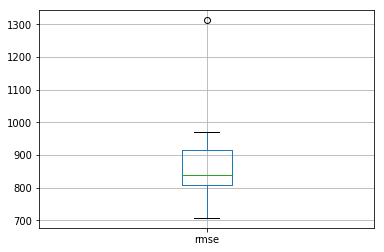

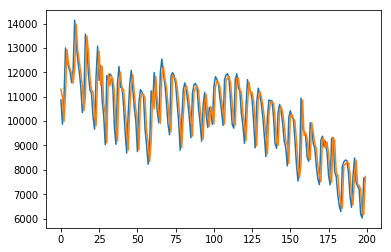

In [36]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
	#return datetime.strptime('190'+x, '%Y-%m')
	return datetime.strptime(x, '%Y-%m-%d')
	#return datetime.strptime(x, '%mm/%dd/%YY')
# ValueError: time data '1902016-01-01' does not match format '%Y-%m'

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 
# load dataset
#series = read_csv('ss2.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = read_csv('AMRNotPaid.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
# take last 200 rows as test data
train, test = supervised_values[0:-200], supervised_values[-200:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 100, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
    
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
		expected = raw_values[len(train) + i + 1]
		print('TestData_Day#=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-200:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

# line plot of observed vs predicted
pyplot.plot(raw_values[-200:])
pyplot.plot(predictions)
pyplot.show()

In [6]:
predictions

[11649.19126611948,
 11731.9339158535,
 10884.838330999017,
 12548.511287093163,
 13110.156321421266,
 12054.861366782337,
 11744.455717466772,
 11718.966815412045,
 11455.697845853865,
 12189.539081722498,
 13205.236135490239,
 12372.159338317811,
 11964.49471990019,
 11868.06005834043,
 11553.53428439796,
 10807.172210425138,
 11897.422996640205,
 13226.177495770156,
 12436.650931149721,
 11346.954633623362,
 11248.577250160277,
 11554.67292714119,
 10632.15782789886,
 10608.8690033257,
 12659.056712687016,
 12487.946674957871,
 11044.011576198041,
 11894.57109760493,
 10463.034225001931,
 10404.1909660995,
 9614.405806779861,
 12466.977796673775,
 11348.167926162481,
 11498.268588662148,
 11365.133030712605,
 10904.80907408148,
 9655.382915832102,
 9775.443830534816,
 12230.408686771989,
 11740.348150290549,
 10785.251018323004,
 11040.535581372678,
 10388.768211983144,
 9703.066045492887,
 9454.428963288665,
 11510.328923404217,
 11375.382375091314,
 11350.863988518715,
 10591.2198

In [14]:
import numpy as np
arr = np.array(predictions)
df = pd.DataFrame(data=arr.flatten())
print(df)

                0
0    11649.191266
1    11731.933916
2    10884.838331
3    12548.511287
4    13110.156321
5    12054.861367
6    11744.455717
7    11718.966815
8    11455.697846
9    12189.539082
10   13205.236135
11   12372.159338
12   11964.494720
13   11868.060058
14   11553.534284
15   10807.172210
16   11897.422997
17   13226.177496
18   12436.650931
19   11346.954634
20   11248.577250
21   11554.672927
22   10632.157828
23   10608.869003
24   12659.056713
25   12487.946675
26   11044.011576
27   11894.571098
28   10463.034225
29   10404.190966
..            ...
170   8142.007533
171   9648.610975
172   8985.722215
173   8459.246804
174   8820.392752
175   8377.744663
176   7687.537225
177   7796.152105
178   9514.215972
179   8865.526780
180   7510.398457
181   7886.377372
182   7329.423528
183   7235.946791
184   7265.978451
185   8800.232524
186   8043.583974
187   7905.996172
188   7854.330521
189   7482.880156
190   6786.174790
191   6860.758982
192   8287.643426
193   8172

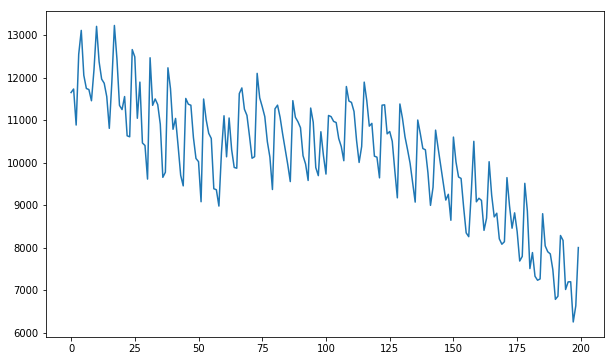

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
df[0].plot();

In [ ]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 100, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-200:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

In [31]:
train_reshaped.shape

(818, 1, 1)

In [15]:
test_scaled

array([[ 4.55407970e-03,  6.26185958e-02],
       [ 6.26185958e-02, -1.36622391e-02],
       [-1.36622391e-02,  2.43137255e-01],
       [ 2.43137255e-01,  3.76091082e-01],
       [ 3.76091082e-01,  5.43959519e-02],
       [ 5.43959519e-02,  7.00822264e-02],
       [ 7.00822264e-02,  8.56419987e-02],
       [ 8.56419987e-02,  5.61669829e-02],
       [ 5.61669829e-02,  1.82163188e-01],
       [ 1.82163188e-01,  3.65464896e-01],
       [ 3.65464896e-01, -8.72865275e-03],
       [-8.72865275e-03,  2.82099937e-02],
       [ 2.82099937e-02,  4.90828590e-02],
       [ 4.90828590e-02,  3.17520557e-02],
       [ 3.17520557e-02, -2.08728653e-02],
       [-2.08728653e-02,  1.68247944e-01],
       [ 1.68247944e-01,  4.61606578e-01],
       [ 4.61606578e-01,  5.56609741e-02],
       [ 5.56609741e-02, -4.23782416e-02],
       [-4.23782416e-02,  3.26375712e-02],
       [ 3.26375712e-02,  9.39911448e-02],
       [ 9.39911448e-02, -1.06261860e-02],
       [-1.06261860e-02,  4.79443390e-02],
       [ 4.

In [16]:
series

date
2016-01-01     5500
2016-01-02     6513
2016-01-03     7602
2016-01-04     8871
2016-01-05     9828
2016-01-06    10103
2016-01-07    10064
2016-01-08     9559
2016-01-09     8881
2016-01-10     9820
2016-01-11    10494
2016-01-12    10273
2016-01-13    10131
2016-01-14     9925
2016-01-15     9306
2016-01-16     8485
2016-01-17     9289
2016-01-18    10242
2016-01-19     9815
2016-01-20     9828
2016-01-21    10052
2016-01-22     8914
2016-01-23     8647
2016-01-24     9214
2016-01-25    10192
2016-01-26    10415
2016-01-27    10421
2016-01-28     9579
2016-01-29     9202
2016-01-30     8564
              ...  
2018-09-16     9223
2018-09-17     9379
2018-09-18     8943
2018-09-19     9176
2018-09-20     8714
2018-09-21     7781
2018-09-22     7384
2018-09-23     9293
2018-09-24     9323
2018-09-25     7923
2018-09-26     7725
2018-09-27     6989
2018-09-28     6512
2018-09-29     6289
2018-09-30     8142
2018-10-01     8332
2018-10-02     8399
2018-10-03     8376
2018-10-04     

In [17]:
test

array([[-8.470e+02, -3.880e+02],
       [-3.880e+02, -9.910e+02],
       [-9.910e+02,  1.039e+03],
       [ 1.039e+03,  2.090e+03],
       [ 2.090e+03, -4.530e+02],
       [-4.530e+02, -3.290e+02],
       [-3.290e+02, -2.060e+02],
       [-2.060e+02, -4.390e+02],
       [-4.390e+02,  5.570e+02],
       [ 5.570e+02,  2.006e+03],
       [ 2.006e+03, -9.520e+02],
       [-9.520e+02, -6.600e+02],
       [-6.600e+02, -4.950e+02],
       [-4.950e+02, -6.320e+02],
       [-6.320e+02, -1.048e+03],
       [-1.048e+03,  4.470e+02],
       [ 4.470e+02,  2.766e+03],
       [ 2.766e+03, -4.430e+02],
       [-4.430e+02, -1.218e+03],
       [-1.218e+03, -6.250e+02],
       [-6.250e+02, -1.400e+02],
       [-1.400e+02, -9.670e+02],
       [-9.670e+02, -5.040e+02],
       [-5.040e+02,  2.168e+03],
       [ 2.168e+03,  1.241e+03],
       [ 1.241e+03, -1.400e+03],
       [-1.400e+03,  6.190e+02],
       [ 6.190e+02, -1.453e+03],
       [-1.453e+03, -6.410e+02],
       [-6.410e+02, -1.169e+03],
       [-1

In [5]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move 
                         forward on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = lstm_model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    preds_moving = scaler.inverse_transform(preds_moving)
    
    return preds_moving

#pyplot.plot(actuals)
pyplot.plot(preds_moving)
pyplot.show()

NameError: name 'preds_moving' is not defined

In [ ]:
# Check this out for predicting ahead......
# https://medium.com/coinmonks/bitcoin-forecasts-with-stateless-lstms-in-tensorflow-bad664db3497
# /Users/akuppam/Documents/Hprog/Py/LSTM/bitcoin-master/bitcoin.ipynb

In [ ]:
# LSTM Book (deep_learning_bundle)

In [77]:
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
# define contrived series
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0] 
series = Series(data)
print(series)

0     10.0
1     20.0
2     30.0
3     40.0
4     50.0
5     60.0
6     70.0
7     80.0
8     90.0
9    100.0
dtype: float64


In [78]:
print(data)

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]


In [84]:
# prepare data for normalization
values = series.values
values

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [90]:
values = values.reshape((len(values), 1))
values

array([[ 10.],
       [ 20.],
       [ 30.],
       [ 40.],
       [ 50.],
       [ 60.],
       [ 70.],
       [ 80.],
       [ 90.],
       [100.]])

In [85]:
len(values)

10

In [89]:
values.reshape(5,2)

array([[ 10.,  20.],
       [ 30.,  40.],
       [ 50.,  60.],
       [ 70.,  80.],
       [ 90., 100.]])

In [91]:
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

Min: 10.000000, Max: 100.000000


In [92]:
# normalize the dataset and print
normalized = scaler.transform(values)
print(normalized)

[[0.        ]
 [0.11111111]
 [0.22222222]
 [0.33333333]
 [0.44444444]
 [0.55555556]
 [0.66666667]
 [0.77777778]
 [0.88888889]
 [1.        ]]


In [93]:
# inverse transform and print
inversed = scaler.inverse_transform(normalized)
print(inversed)

[[ 10.]
 [ 20.]
 [ 30.]
 [ 40.]
 [ 50.]
 [ 60.]
 [ 70.]
 [ 80.]
 [ 90.]
 [100.]]


In [94]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = ['cold', 'cold', 'warm', 'cold', 'hot', 'hot', 'warm', 'cold', 'warm', 'hot'] 
values = array(data)
print(values)

['cold' 'cold' 'warm' 'cold' 'hot' 'hot' 'warm' 'cold' 'warm' 'hot']


In [95]:
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

[0 0 2 0 1 1 2 0 2 1]


In [96]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [97]:
# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])]) 
print(inverted)

['cold']


In [98]:
from keras.preprocessing.sequence import pad_sequences
# define sequences
sequences = [
  [1, 2, 3, 4],
    [1, 2, 3],
[1] ]
# pad sequence
padded = pad_sequences(sequences)
print(padded)

[[1 2 3 4]
 [0 1 2 3]
 [0 0 0 1]]


In [99]:
sequences

[[1, 2, 3, 4], [1, 2, 3], [1]]

In [100]:
from keras.preprocessing.sequence import pad_sequences
# define sequences
sequences = [
  [1, 2, 3, 4],
    [1, 2, 3],
[1] ]
# pad sequence
padded = pad_sequences(sequences, padding='post') 
print(padded)

[[1 2 3 4]
 [1 2 3 0]
 [1 0 0 0]]


In [101]:
from pandas import DataFrame
# define the sequence
df = DataFrame()
df['t'] = [x for x in range(10)] 
print(df)

   t
0  0
1  1
2  2
3  3
4  4
5  5
6  6
7  7
8  8
9  9


In [103]:
from pandas import DataFrame
# define the sequence
df = DataFrame()
df['t'] = [x for x in range(10)] # shift forward
df['t-1'] = df['t'].shift(1) 
print(df)

   t  t-1
0  0  NaN
1  1  0.0
2  2  1.0
3  3  2.0
4  4  3.0
5  5  4.0
6  6  5.0
7  7  6.0
8  8  7.0
9  9  8.0


In [104]:
from pandas import DataFrame
# define the sequence
df = DataFrame()
df['t'] = [x for x in range(10)] # shift backward
df['t+1'] = df['t'].shift(-1) 
print(df)

   t  t+1
0  0  1.0
1  1  2.0
2  2  3.0
3  3  4.0
4  4  5.0
5  5  6.0
6  6  7.0
7  7  8.0
8  8  9.0
9  9  NaN


In [1]:
# https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
from numpy import array
data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
data = data.reshape((1, 10, 1))
print(data.shape)

(1, 10, 1)
